### Implementing LSTM Nueral Network

### Data Preparation

In [76]:
import torch
import torch.nn as nn
import pandas as pd
import sys
sys.path.append(r'C:\Projects\ML Stock Predictor\MLStockPredictor\src')
import data_preparation as dp

df_lstm = dp.download_stock_data('AAPL', '2010-01-01', '2023-10-01')
df_lstm = dp.add_target(df_lstm)
# df_lstm = df_lstm[df_lstm.index.weekday == 4]

df_scaled, scaler = dp.scale_features(df_lstm.drop(columns=['Target']))
df_scaled['Target'] = df_lstm['Target']  # Add target back

features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'
# target = 'Target'
df_lstm.sort_index(inplace=True)

seq_len = 30
X_all, y_all = dp.create_lstm_sequences(df_scaled, features, target, seq_len)

print(df_lstm.head())

[*********************100%***********************]  1 of 1 completed

Price           Open      High       Low     Close      Volume Target
Ticker          AAPL      AAPL      AAPL      AAPL        AAPL       
Date                                                                 
2010-01-08  6.320395  6.371487  6.283128  6.370886   447610800      0
2010-01-15  6.339329  6.359466  6.187255  6.189058   594067600      0
2010-01-22  6.214606  6.236245  5.925485  5.943217   881767600      0
2010-01-29  6.043295  6.076955  5.717808  5.772206  1245952400      1
2010-02-05  5.789339  5.890622  5.735842  5.874392   850306800      1



C:\Users\Baile\AppData\Local\Temp\ipykernel_20580\2471398444.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_scaled, scaler = dp.scale_features(df_lstm.drop(columns=['Target']))


### Data Split

In [77]:
# splitting sequentially same as before
train_size = int(len(X_all) * 0.8)
X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

# convert to pytorch tensors
X_train_t = torch.tensor(X_train)
# unsqueeze is to add an extra dimension so that it matches the output shape
y_train_t = torch.tensor(y_train).unsqueeze(-1)
X_test_t  = torch.tensor(X_test)
y_test_t  = torch.tensor(y_test).unsqueeze(-1)

### Model Definition

In [78]:
# class for calling the LSTM model and then a fully connected layer
class LSTMRegressor(nn.Module):
    # there are more parameters to mess around with for the model, but I kept it pretty simple for now
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        # fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # pass input through LSTM for predictions
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_step = lstm_out[:, -1, :]
        y_pred = self.fc(last_step)
        return y_pred

### Model Training

In [79]:
import torch.optim as optim
# create model with number of features as the input size
model = LSTMRegressor(input_size=len(features), hidden_size=64, num_layers=2, output_size=1)
# define loss function
criterion = nn.MSELoss()
# optimizer for updating model params
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
# training mode
model.train()

# Values to play around with, epochs run quite fast on GPU
num_epochs = 500
batch_size = 32

# training loop
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train_t), batch_size):
        x_batch = X_train_t[i : i + batch_size]
        y_batch = y_train_t[i : i + batch_size]

        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    # printing results every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / (len(X_train_t) // batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    scheduler.step()

Epoch 10/500, Loss: 0.0068
Epoch 20/500, Loss: 0.0106
Epoch 30/500, Loss: 0.0074
Epoch 40/500, Loss: 0.0069
Epoch 50/500, Loss: 0.0056
Epoch 60/500, Loss: 0.0048
Epoch 70/500, Loss: 0.0031
Epoch 80/500, Loss: 0.0053
Epoch 90/500, Loss: 0.0036
Epoch 100/500, Loss: 0.0055
Epoch 110/500, Loss: 0.0021
Epoch 120/500, Loss: 0.0020
Epoch 130/500, Loss: 0.0020
Epoch 140/500, Loss: 0.0020
Epoch 150/500, Loss: 0.0019
Epoch 160/500, Loss: 0.0019
Epoch 170/500, Loss: 0.0019
Epoch 180/500, Loss: 0.0018
Epoch 190/500, Loss: 0.0018
Epoch 200/500, Loss: 0.0018
Epoch 210/500, Loss: 0.0018
Epoch 220/500, Loss: 0.0018
Epoch 230/500, Loss: 0.0018
Epoch 240/500, Loss: 0.0018
Epoch 250/500, Loss: 0.0018
Epoch 260/500, Loss: 0.0018
Epoch 270/500, Loss: 0.0017
Epoch 280/500, Loss: 0.0017
Epoch 290/500, Loss: 0.0017
Epoch 300/500, Loss: 0.0017
Epoch 310/500, Loss: 0.0017
Epoch 320/500, Loss: 0.0017
Epoch 330/500, Loss: 0.0017
Epoch 340/500, Loss: 0.0017
Epoch 350/500, Loss: 0.0017
Epoch 360/500, Loss: 0.0017
E

### Model Evaluation

In [80]:
# evaluation mode
model.eval()
with torch.no_grad():
    # test predictions and loss
    y_pred_test = model(X_test_t)
    test_loss = criterion(y_pred_test, y_test_t).item()

print("Test MSE:", test_loss)

Test MSE: 0.0585273914039135


### Results Visualization

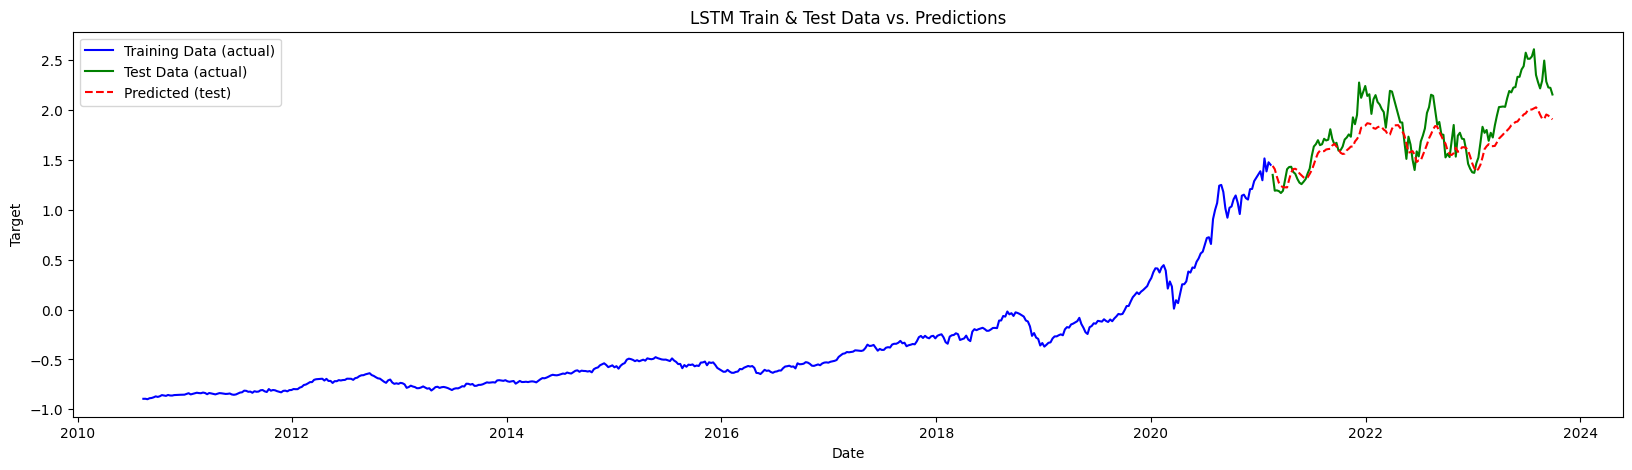

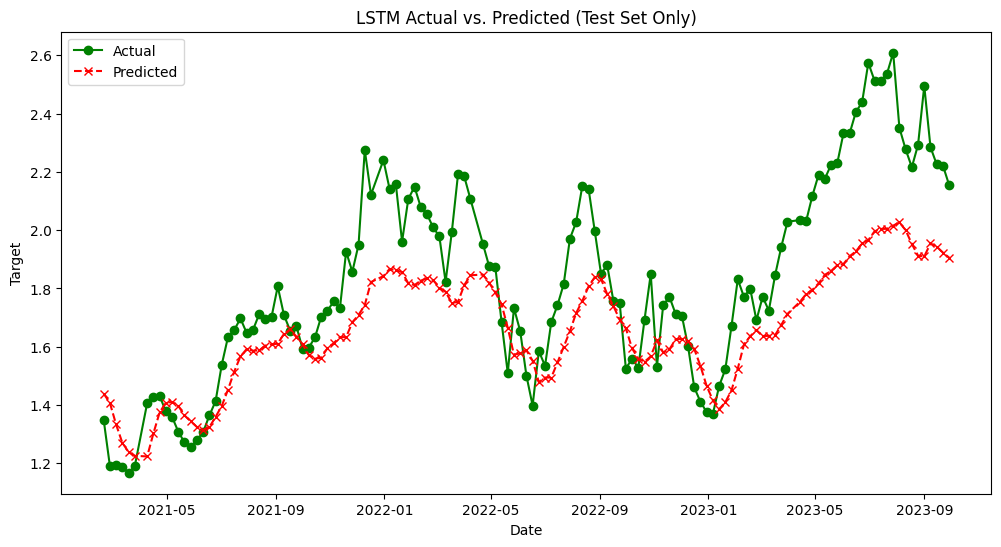

In [81]:
import matplotlib.pyplot as plt
import numpy as np

all_indices = df_lstm.index[seq_len:]
train_size = len(X_train)
test_size = len(X_test)

train_indices = all_indices[:train_size]
test_indices  = all_indices[train_size:]

y_train_np = np.array(y_train).flatten()
y_test_np = np.array(y_test).flatten()
y_pred_test_np = y_pred_test.flatten()

plt.figure(figsize=(20, 5))

plt.plot(train_indices, y_train_np, label='Training Data (actual)', color='blue')
plt.plot(test_indices, y_test_np, label='Test Data (actual)', color='green')
plt.plot(test_indices, y_pred_test_np, label='Predicted (test)', color='red', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Target")
plt.title("LSTM Train & Test Data vs. Predictions")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_indices, y_test_np, label='Actual', marker='o', linestyle='-', color='green')
plt.plot(test_indices, y_pred_test_np, label='Predicted', marker='x', linestyle='--', color='red')

plt.xlabel("Date")
plt.ylabel("Target")
plt.title("LSTM Actual vs. Predicted (Test Set Only)")
plt.legend()
plt.show()

### LSTM Classifier

In [82]:
import data_preparation as dp
import torch, pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# Use np.nan wherever you need a NaN value

# download
df = dp.download_stock_data("ENB", "2010-01-01", "2023-10-01")
# df.index = pd.to_datetime(df.index)
# df = df.resample("W-FRI").last().dropna()

df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(inplace=True)
df['Return'] = df['Close'].pct_change()
df['SMA_ratio'] = df['Close'] / df['Close'].rolling(4).mean()
df['Volatility_4w'] = df['Close'].pct_change().rolling(4).std()
df['Momentum_4w']   = df['Close'] / df['Close'].shift(4) - 1

delta = df["Close"].diff()

gain = (delta.where(delta > 0, 0.0))
loss = (-delta.where(delta < 0, 0.0))

# exponential moving average
roll_up   = gain.ewm(alpha=1/14, adjust=False).mean()
roll_down = loss.ewm(alpha=1/14, adjust=False).mean()

rs  = roll_up / roll_down
df["RSI_14"] = 100 - (100 / (1 + rs))


# OBV (On-Balance Volume)
def _obv(close, volume):
    direction = np.sign(close.diff()).fillna(0)
    return (volume * direction).cumsum()

df["OBV"] = _obv(df["Close"], df["Volume"])

# MACD difference
ema12 = df["Close"].ewm(span=12, adjust=False).mean()
ema26 = df["Close"].ewm(span=26, adjust=False).mean()
macd  = ema12 - ema26
signal = macd.ewm(span=9, adjust=False).mean()
df["MACD_diff"] = macd - signal

df.dropna(inplace=True)

print(df.head())

# scale features
features = ["Open", "High", "Low", "Close", "Volume", "Return", "SMA_ratio", "Volatility_4w", "Momentum_4w", "RSI_14", "OBV", "MACD_diff"]
# features = ["Return", "SMA_ratio", "Volatility_4w", "Momentum_4w", "RSI_14", "OBV", "MACD_diff"]
df_scaled, scaler = dp.scale_features(df[features])
df_scaled["Target"] = df["Target"]

# create LSTM sequences
seq_len = 30
X, y = dp.create_lstm_sequences(df_scaled, features, "Target", seq_len)

# split and tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(-1)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)


[*********************100%***********************]  1 of 1 completed

Price            Open       High        Low      Close  Volume Target  \
Ticker            ENB        ENB        ENB        ENB     ENB          
Date                                                                    
2010-02-05  11.310983  11.382410  11.022723  11.183434  876600      1   
2010-02-12  11.293044  11.468090  11.285322  11.442348  799200      1   
2010-02-19  11.421757  11.545319  11.421757  11.457796  892800      0   
2010-02-26  11.341957  11.416609  11.257008  11.398589  369000      1   
2010-03-05  11.867098  11.970066  11.831059  11.892840  433200      1   

Price         Return SMA_ratio Volatility_4w Momentum_4w     RSI_14  \
Ticker                                                                
Date                                                                  
2010-02-05  0.008512  0.992642      0.014913   -0.045504  14.855376   
2010-02-12  0.023152  1.018188      0.022528   -0.009823  40.823607   
2010-02-19  0.001350  1.014579      0.015112    0.019649  41

In [83]:
import torch.nn as nn
import torch.optim as optim

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2,dropout_rate=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout_rate if num_layers > 1 else 0.0)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)


In [84]:
model = LSTMClassifier(input_size=len(features), hidden_size=64, num_layers=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1:02d}/{num_epochs} | BCE {running/len(train_loader.dataset):.4f}")


Epoch 100/600 | BCE 0.1563
Epoch 200/600 | BCE 0.0223
Epoch 300/600 | BCE 0.0062
Epoch 400/600 | BCE 0.0111
Epoch 500/600 | BCE 0.0026
Epoch 600/600 | BCE 0.0330


### Evaluation and certainty

In [85]:
model.eval()
with torch.no_grad():
    test_logits = model(X_test)
    probs = torch.sigmoid(test_logits)
    preds = (probs >= 0.5).float()

bce   = criterion(test_logits, y_test).item()
acc   = (preds == y_test).float().mean().item()
print(f"Test  BCE: {bce:.4f}  |  Accuracy: {acc:.3f}")



Test  BCE: 2.5562  |  Accuracy: 0.530


### Plot and confusion matrix

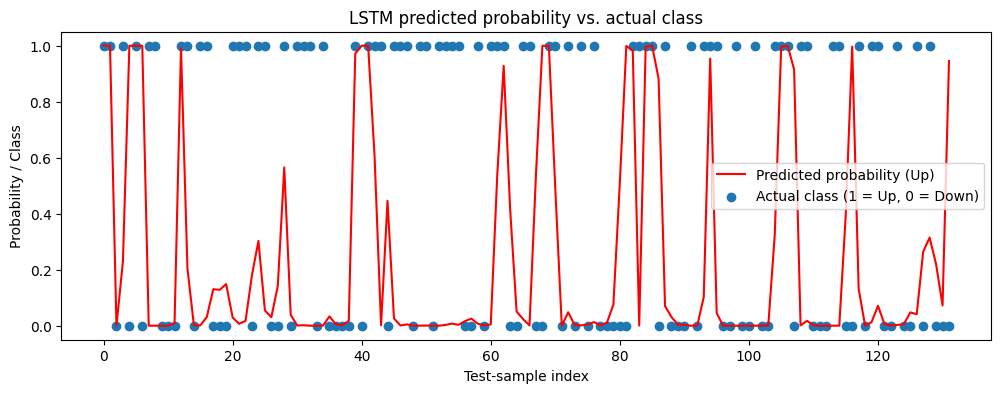

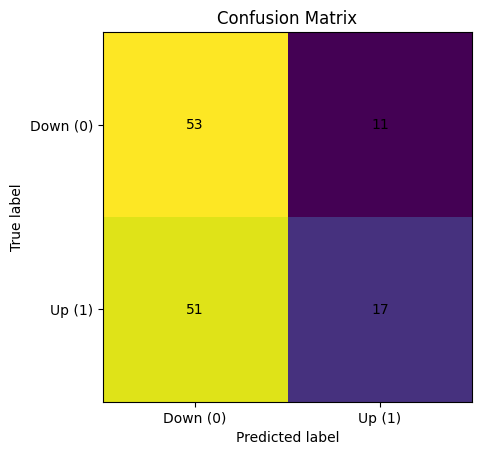

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get probabilities and make class predictions
probs = torch.sigmoid(test_logits).squeeze().cpu().numpy()
y_true = y_test.squeeze().cpu().numpy()
preds  = (probs >= 0.5).astype(int)

# Probability vs Actual plot
plt.figure(figsize=(12, 4))
plt.plot(probs, label='Predicted probability (Up)', color='red')
plt.scatter(range(len(y_true)), y_true,
            label='Actual class (1 = Up, 0 = Down)', marker='o')
plt.xlabel("Test-sample index")
plt.ylabel("Probability / Class")
plt.title("LSTM predicted probability vs. actual class")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, preds)

fig, ax = plt.subplots()
ax.imshow(cm)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Down (0)", "Up (1)"])
ax.set_yticks([0, 1])
ax.set_yticklabels(["Down (0)", "Up (1)"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.show()




In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, precision_score, recall_score
)

# ── 1  Prepare tabular feature matrix X and label y ─────────────────
features = [
    "Open","High","Low","Close","Volume",
    "Return","SMA_ratio","Volatility_4w",
    "Momentum_4w","RSI_14","OBV"       # add MACD_diff or SPY_ret if created
]

X = df[features].values               # 2-D numpy array
y = df["Target"].values               # 1-D (0 / 1)

# Keep temporal order: no shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)
class_wt = compute_class_weight('balanced', classes=np.array([0,1]), y=y_train)
# ── 2  Train Gradient-Boosted Tree ──────────────────────────────────
gbt = GradientBoostingClassifier(
        n_estimators=800, learning_rate=0.03, max_depth=3,
        subsample=0.8, random_state=42,
)
gbt.fit(X_train, y_train, sample_weight=np.where(y_train==1,class_wt[1],class_wt[0]))

# ── 3  Evaluate ─────────────────────────────────────────────────────
probs_test = gbt.predict_proba(X_test)[:, 1]      # certainty of “up”
preds_test = (probs_test >= 0.5).astype(int)

print("Accuracy     :", accuracy_score(y_test, preds_test))
print("ROC-AUC      :", roc_auc_score(y_test, probs_test))
print("Precision(1) :", precision_score(y_test, preds_test))
print("Recall(1)    :", recall_score(y_test, preds_test))
print("Confusion\n",   confusion_matrix(y_test, preds_test))


Accuracy     : 0.4927536231884058
ROC-AUC      : 0.5513979398780745
Precision(1) : 0.52
Recall(1)    : 0.18309859154929578
Confusion
 [[55 12]
 [58 13]]
